In [1]:
import numpy as np
import matplotlib.pyplot as plot 

from value_estimation import MarkovDecisionProcess, MDPEnvironment, Policy, calculate_value_function_iterative, OfflineMonteCarloEstimator, OnlineMonteCarloEstimator, TemporalDifferenceEstimator, make_uniform_policy, run, ConstantLearningRate, LinearLearningRate, MixingMultiStepEstimator

In [2]:
transition_probabilities = np.array([
    [[0, 1, 0, 0]],
    [[0, 0, 1, 0]],
    [[0, 0, 0, 1]],
    [[0, 0, 0, 1]]
])

rewards = np.array([
    [1],
    [1],
    [1],
    [0],
])

action_probabilities = np.array([[1], [1], [1], [1]])

mdp = MarkovDecisionProcess(transition_probabilities, rewards, 0.9)
policy = Policy(action_probabilities)

calculate_value_function_iterative(mdp, policy)

array([2.71, 1.9 , 1.  , 0.  ])

In [3]:
# 0 -> left, 1 -> right
def make_random_walk_mdp(size, discount) -> MarkovDecisionProcess:
    transition_probabilities = np.zeros(shape=(size+1, 2, size+1))

    for state_index in range(size):
        transition_probabilities[state_index, 0, (state_index - 1) if state_index > 0 else size] = 1
        transition_probabilities[state_index, 1, (state_index + 1) if state_index < size - 1 else size] = 1
    transition_probabilities[size, :, size] = 1

    rewards = np.zeros(shape=(size+1, 2))
    rewards[size-1, 1] = 1

    return MarkovDecisionProcess(transition_probabilities, rewards, discount)

def make_random_walk_environment(size, discount) -> MDPEnvironment:
    initial_state = size // 2

    mdp = make_random_walk_mdp(size, discount)
    return MDPEnvironment(mdp, initial_state, {size})

In [4]:
mdp = make_random_walk_mdp(7, 1.0)

calculate_value_function_iterative(mdp, policy=make_uniform_policy(mdp))

array([0.12490891, 0.2498445 , 0.37478009, 0.49978009, 0.62478009,
       0.7498445 , 0.87490891, 0.        ])

Real value function [0.16666648 0.33333305 0.49999962 0.66666638 0.83333314 0.        ]


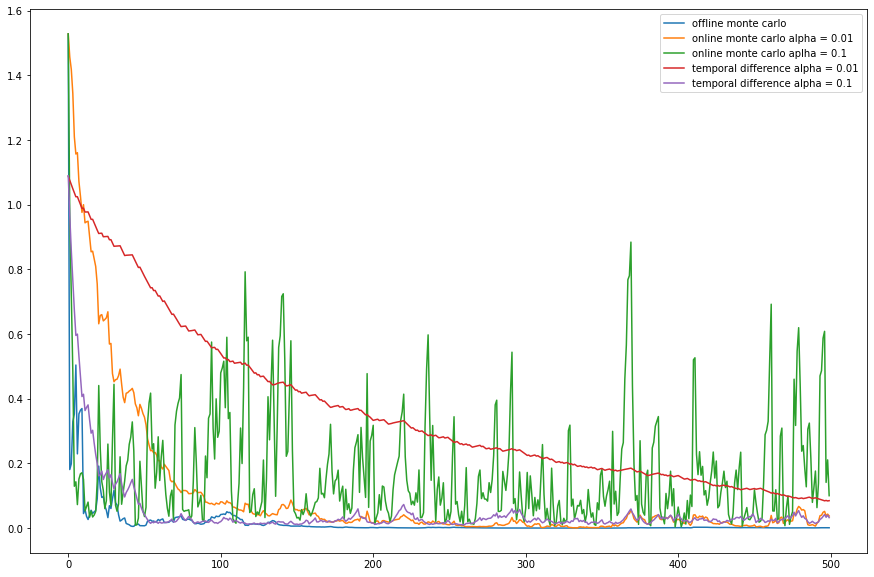

In [9]:
environment = make_random_walk_environment(5, 1)

mdp = environment.mdp
uniform_policy = make_uniform_policy(mdp)

real_value_function = calculate_value_function_iterative(mdp, policy=uniform_policy)
print("Real value function", real_value_function)

value_estimators = {
    "offline monte carlo": OfflineMonteCarloEstimator(mdp.n_states, mdp.n_actions, mdp.discount),
    "online monte carlo alpha = 0.01": OnlineMonteCarloEstimator(mdp.n_states, mdp.n_actions, mdp.discount, ConstantLearningRate(0.01)),
    "online monte carlo aplha = 0.1": OnlineMonteCarloEstimator(mdp.n_states, mdp.n_actions, mdp.discount, ConstantLearningRate(0.1)),
    "temporal difference alpha = 0.01": TemporalDifferenceEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 0.1, ConstantLearningRate(0.01)),
    "temporal difference alpha = 0.1": TemporalDifferenceEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 0.1, ConstantLearningRate(0.1)),
}

loss_histories = run(environment, uniform_policy, value_estimators, 5_00, real_value_function=real_value_function)

fig, axis = plot.subplots(1, 1, figsize=[15, 10])

for name, loss_history in loss_histories.items():
    axis.plot(loss_history, label=name)
axis.legend()

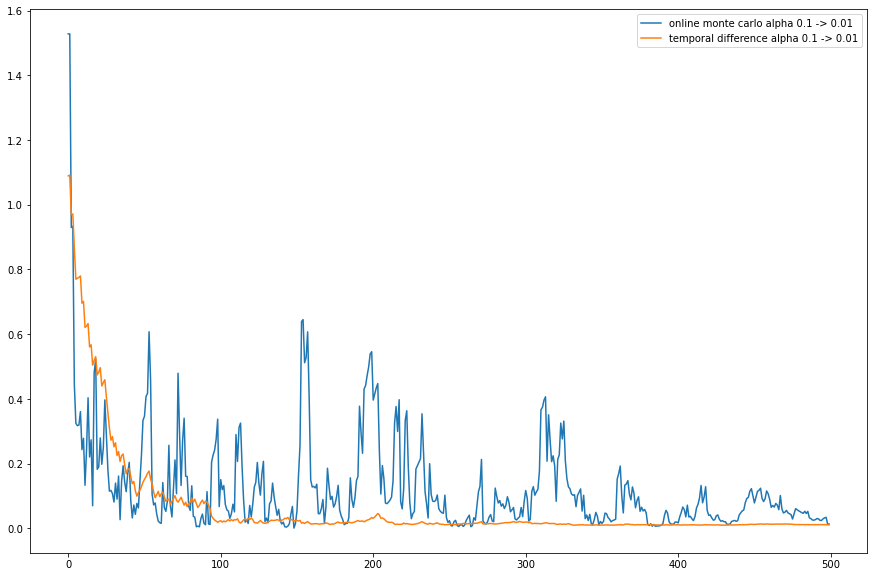

In [6]:
n_episodes = 500

value_estimators = {
    "online monte carlo alpha 0.1 -> 0.01": OnlineMonteCarloEstimator(mdp.n_states, mdp.n_actions, mdp.discount, LinearLearningRate(0.1, 0.01, n_episodes)),
    "temporal difference alpha 0.1 -> 0.01": TemporalDifferenceEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 0.1, LinearLearningRate(0.1, 0.01, n_episodes)),
}

loss_histories = run(environment, uniform_policy, value_estimators, n_episodes, real_value_function=real_value_function)

fig, axis = plot.subplots(1, 1, figsize=[15, 10])

for name, loss_history in loss_histories.items():
    axis.plot(loss_history, label=name)
axis.legend()

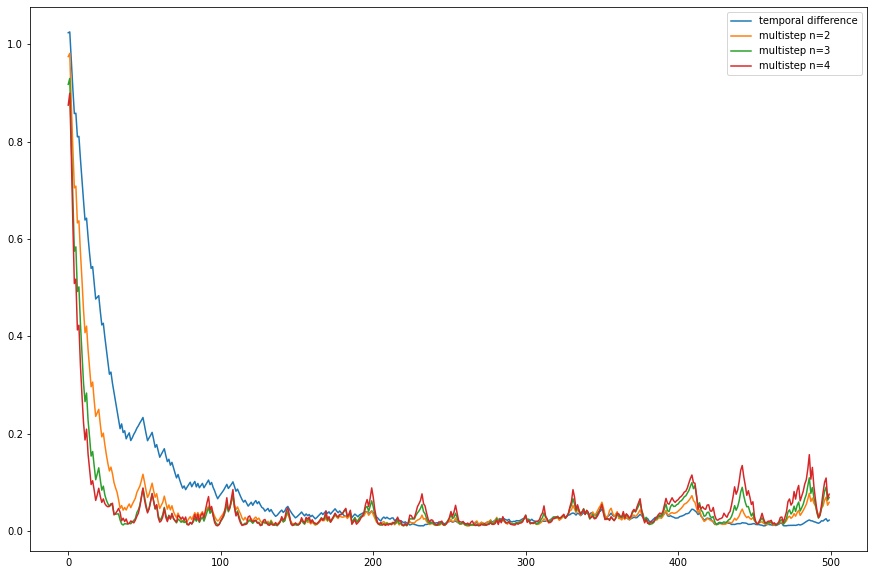

In [7]:
n_episodes = 500

value_estimators = {
    "temporal difference": TemporalDifferenceEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 0.1, ConstantLearningRate(0.05)),
    "multistep n=2": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 2, 1, 0.1, ConstantLearningRate(0.05)),
    "multistep n=3": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 3, 1, 0.1, ConstantLearningRate(0.05)),
    "multistep n=4": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount, 4, 1, 0.1, ConstantLearningRate(0.05)),
}

loss_histories = run(environment, uniform_policy, value_estimators, n_episodes, real_value_function=real_value_function)

fig, axis = plot.subplots(1, 1, figsize=[15, 10])

for name, loss_history in loss_histories.items():
    axis.plot(loss_history, label=name)
axis.legend()

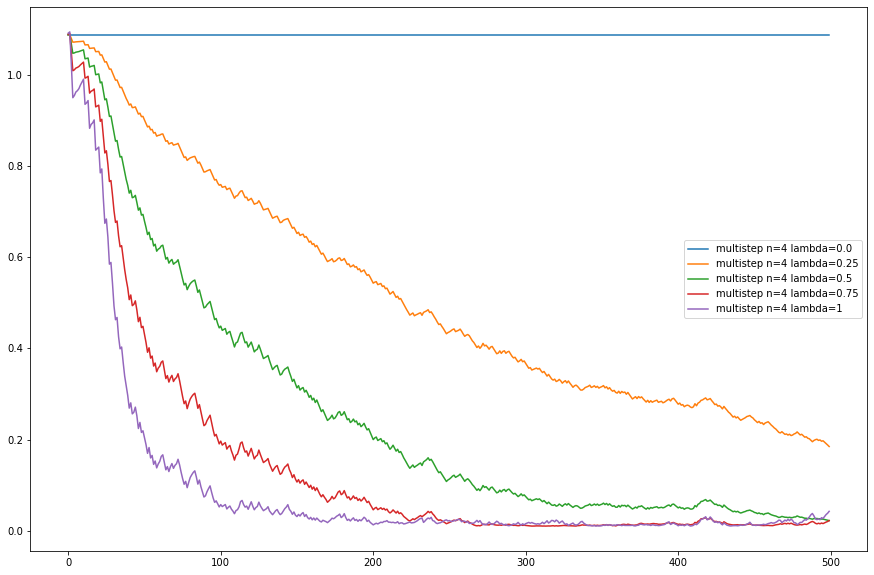

In [8]:
n_episodes = 500

value_estimators = {
    "multistep n=4 lambda=0.0": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount,     4, 0.0, 0.1, ConstantLearningRate(0.02)),
    "multistep n=4 lambda=0.25": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount,    4, 0.25, 0.1, ConstantLearningRate(0.02)),
    "multistep n=4 lambda=0.5": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount,     4, 0.5, 0.1, ConstantLearningRate(0.02)),
    "multistep n=4 lambda=0.75": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount,    4, 0.75, 0.1, ConstantLearningRate(0.02)),
    "multistep n=4 lambda=1": MixingMultiStepEstimator(mdp.n_states, mdp.n_actions, mdp.discount,       4, 1, 0.1, ConstantLearningRate(0.02)),
}

loss_histories = run(environment, uniform_policy, value_estimators, n_episodes, real_value_function=real_value_function)

fig, axis = plot.subplots(1, 1, figsize=[15, 10])

for name, loss_history in loss_histories.items():
    axis.plot(loss_history, label=name)
axis.legend()